In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy.stats
import numpy as np
import re

In [2]:
#From: https://stackoverflow.com/questions/4813061/non-alphanumeric-list-order-from-os-listdir
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [3]:
df_list = []
glob_list = glob.glob("model_analyses\\train//"+"//**//*o.csv", recursive = True) #searcg all the analyses to find the CSV's

ordered_glob_list = sorted_alphanumeric(glob_list) #problems with default ordering

for csv in ordered_glob_list:
    df_list.append([pd.read_csv(csv),csv]) #create and store a tuple which contains the dataframe and the directory
    print(csv)

model_analyses\train\aae-128_peptide_latent32_train\saved_info.csv
model_analyses\train\aae-128_peptide_latent64_train\saved_info.csv
model_analyses\train\aae-128_peptide_latent128_train\saved_info.csv
model_analyses\train\rnn-128_peptide_latent32_train\saved_info.csv
model_analyses\train\rnn-128_peptide_latent64_train\saved_info.csv
model_analyses\train\rnn-128_peptide_latent128_train\saved_info.csv
model_analyses\train\rnnattn-128_peptide_latent32_train\saved_info.csv
model_analyses\train\rnnattn-128_peptide_latent64_train\saved_info.csv
model_analyses\train\rnnattn-128_peptide_latent128_train\saved_info.csv
model_analyses\train\trans1x-128_peptide_latent32_train\saved_info.csv
model_analyses\train\trans1x-128_peptide_latent64_train\saved_info.csv
model_analyses\train\trans1x-128_peptide_latent128_train\saved_info.csv
model_analyses\train\wae-128_peptide_latent32_train\saved_info.csv
model_analyses\train\wae-128_peptide_latent64_train\saved_info.csv
model_analyses\train\wae-128_pepti

In [4]:
#some scores need confidence intervals calculated which is done below. Also the model name is appended at the end of the df
#also store the results to be printed in a "metric_list"
metric_list=[]
i=0
for df_tuple in df_list:
    entropies=df_tuple[0].loc[:,'mu_entropies']
    metric_list.append([entropies.dropna(),'latent mean entropies'])
    print(i)
    for col in df_tuple[0].loc[:,'latent_mem_func_silhouette':'latent_to_PCA_cohesiveness']:
        samples=df_tuple[0].loc[:,col]
        conf=scipy.stats.t.interval(0.95, len(samples)-1,np.mean(samples.dropna()), scipy.stats.sem(samples.dropna()))
        df_tuple[0]=pd.concat([df_tuple[0],pd.DataFrame({'{}'.format(col+' conf'):conf})], axis=1)
        metric_list.append([samples.dropna(),'{}'.format(col)])

    df_tuple[0]['model'] = df_tuple[1] #add a column with the model name
    metric_list.append(df_tuple[1])
    i+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [5]:
namelist=[sublist for sublist in metric_list if isinstance(sublist, str)] #leave the sublist only pick up strings with names
model_names = [temp_list[:].split('\\')[-2] for temp_list in namelist]
print(model_names)

['aae-128_peptide_latent32_train', 'aae-128_peptide_latent64_train', 'aae-128_peptide_latent128_train', 'rnn-128_peptide_latent32_train', 'rnn-128_peptide_latent64_train', 'rnn-128_peptide_latent128_train', 'rnnattn-128_peptide_latent32_train', 'rnnattn-128_peptide_latent64_train', 'rnnattn-128_peptide_latent128_train', 'trans1x-128_peptide_latent32_train', 'trans1x-128_peptide_latent64_train', 'trans1x-128_peptide_latent128_train', 'wae-128_peptide_latent32_train', 'wae-128_peptide_latent64_train', 'wae-128_peptide_latent128_train']


In [6]:
#shortens the names to fit well in the plots
namelist=[sublist for sublist in metric_list if isinstance(sublist, str)] #leave the sublist only pick up strings with names
model_names = [temp_list[:].split('\\')[-2] for temp_list in namelist]
model_names = [names.split('_')[0][:-4]+'-'+names.split('_')[2][6:] for names in model_names] 

In [7]:
max_silhouette_list = []

for df in df_list:
    argmax = np.argmax(abs(df[0].loc[:,'pca_func_silhouette[0,1]':'pca_func_silhouette[3,4]'].dropna().mean(0)))
    curr_df =abs(df[0].loc[:,'pca_func_silhouette[0,1]':'pca_func_silhouette[3,4]'].dropna())
    max_silhouette_list.append(curr_df.loc[:,curr_df.columns[argmax]])
#     print(df[1],'\n')
    print(np.argmax(abs(df[0].loc[:,'pca_func_silhouette[0,1]':'pca_func_silhouette[3,4]'].dropna().mean(0))))
#     print(np.max(abs(df[0].loc[:,'pca_func_silhouette[0,1]':'pca_func_silhouette[3,4]'].dropna().mean(0))))
#     print(abs(df[0].loc[:,'pca_func_silhouette[0,1]':'pca_func_silhouette[3,4]'].dropna().mean(0)))
    print(curr_df.loc[:,curr_df.columns[argmax]])
#     print(df[0].loc[:,'pca_func_silhouette[0,1]':'pca_func_silhouette[3,4]'].dropna().mean(axis=1))

3
0     0.087399
1     0.102865
2     0.076229
3     0.085208
4     0.104251
5     0.079511
6     0.094021
7     0.096503
8     0.078672
9     0.052071
10    0.083849
11    0.056849
12    0.066505
13    0.047444
14    0.077359
Name: pca_func_silhouette[0,4], dtype: float64
8
0     0.289196
1     0.355578
2     0.323462
3     0.324127
4     0.331267
5     0.318178
6     0.337941
7     0.308060
8     0.357515
9     0.315301
10    0.329708
11    0.342827
12    0.323579
13    0.385554
14    0.325892
Name: pca_func_silhouette[2,4], dtype: float64
5
0     0.440703
1     0.434469
2     0.421651
3     0.392531
4     0.417229
5     0.398342
6     0.411311
7     0.408326
8     0.392003
9     0.435061
10    0.417449
11    0.439781
12    0.428571
13    0.404431
14    0.426115
Name: pca_func_silhouette[1,3], dtype: float64
7
0     0.117726
1     0.151222
2     0.160102
3     0.160767
4     0.142885
5     0.061734
6     0.105867
7     0.145177
8     0.122808
9     0.143566
10    0.118761
11    0.138

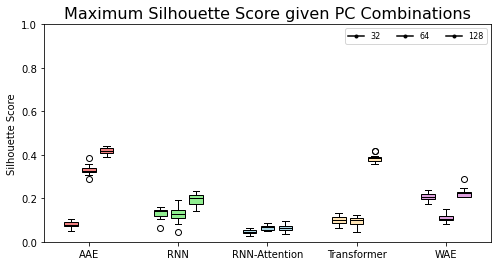

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=9)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize


color_list = ['lightcoral','lightcoral','lightcoral',
              'lightgreen','lightgreen','lightgreen',
              'lightblue','lightblue','lightblue',
              'moccasin','moccasin','moccasin',
              'plum','plum','plum']

pos=[0.8,1,1.2, 1.8,2,2.2, 2.8,3,3.2, 3.8,4,4.2, 4.8,5,5.2]

box_1 = ax.boxplot(x=max_silhouette_list,positions=pos,widths=0.15,patch_artist=True);

for patch, color in zip(box_1['boxes'], color_list):
    patch.set_facecolor(color)

        
plt.setp(box_1['medians'],color='black');
ax.set_title('Maximum Silhouette Score given PC Combinations')
ax.set_ylabel('Silhouette Score')
ax.set_xticklabels(['-','AAE','-','-','RNN','-','-','RNN-Attention','-','-','Transformer','-','-','WAE','-'])
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlim(0.5,5.5)
#ax.set_yticks(np.linspace(0,1,11))
ax.set_ylim(0,1)
kp, = plt.plot([],'k.-')
ax.legend((kp,kp,kp),['32','64','128'],ncol=3, loc='upper right');
plt.savefig('max_silhouette.jpg', transparent=None, dpi=200)

In [9]:
box_1['whiskers'][0]

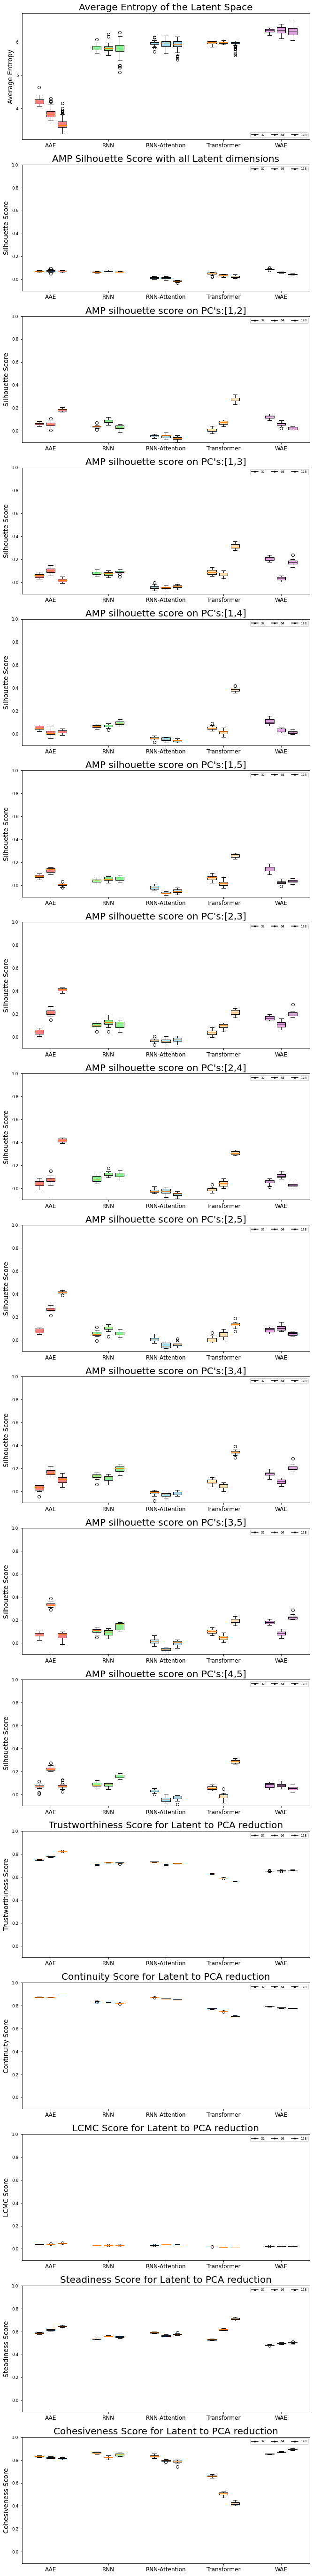

In [10]:
fig, ax = plt.subplots((len(metric_list)//len(namelist)-1),1, figsize=(11,100))

color_list =['lightcoral','lightgreen','lightblue','moccasin','plum']

title_list=['Average Entropy of the Latent Space', 'AMP Silhouette Score with all Latent dimensions',
            'AMP silhouette score on PC\'s:[1,2]','AMP silhouette score on PC\'s:[1,3]',
            'AMP silhouette score on PC\'s:[1,4]','AMP silhouette score on PC\'s:[1,5]',
            'AMP silhouette score on PC\'s:[2,3]','AMP silhouette score on PC\'s:[2,4]',
            'AMP silhouette score on PC\'s:[2,5]','AMP silhouette score on PC\'s:[3,4]',
            'AMP silhouette score on PC\'s:[3,5]','AMP silhouette score on PC\'s:[4,5]',
            'Trustworthiness Score for Latent to PCA reduction', 'Continuity Score for Latent to PCA reduction',
           'LCMC Score for Latent to PCA reduction', 'Steadiness Score for Latent to PCA reduction',
           'Cohesiveness Score for Latent to PCA reduction',]
y_labels=['Average Entropy', 'Silhouette Score',
          'Silhouette Score','Silhouette Score','Silhouette Score','Silhouette Score','Silhouette Score',
          'Silhouette Score','Silhouette Score','Silhouette Score','Silhouette Score','Silhouette Score',
          'Trustworthiness Score','Continuity Score',
          'LCMC Score','Steadiness Score', 'Cohesiveness Score']

SMALL_SIZE = 7
MEDIUM_SIZE = 17
BIGGER_SIZE = 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

pos=[0.8,1,1.2]

max_silhouette = {'aae32':0, 'aae64':0, 'aae128':0, 'rnn32':0, 'rnn64':0, 'rnn128':0, 'rnnatt32':0, 'rnnatt64':0,
                 'rnnatt128':0, 'trans32':0, 'trans64':0, 'trans128':0, 'wae32':0, 'wae64':0, 'wae128':0}

for col in range((len(metric_list)//len(namelist)-1)):
    box_1 = ax[col].boxplot(x=[elmt[0] for elmt in metric_list[col:3*(len(metric_list)//len(namelist)):(len(metric_list)//len(namelist))]],
                positions=pos,widths=0.15,patch_artist=True)
    box_2 = ax[col].boxplot(x=[elmt[0] for elmt in metric_list[col+3*(len(metric_list)//len(namelist)):6*(len(metric_list)//len(namelist)):(len(metric_list)//len(namelist))]],
                positions=np.array(pos)+1,widths=0.15, patch_artist=True)
    box_3 = ax[col].boxplot(x=[elmt[0] for elmt in metric_list[col+6*(len(metric_list)//len(namelist)):9*(len(metric_list)//len(namelist)):(len(metric_list)//len(namelist))]],
                positions=np.array(pos)+2,widths=0.15, patch_artist=True)
    box_4 = ax[col].boxplot(x=[elmt[0] for elmt in metric_list[col+9*(len(metric_list)//len(namelist)):12*(len(metric_list)//len(namelist)):(len(metric_list)//len(namelist))]],
                positions=np.array(pos)+3,widths=0.15, patch_artist=True)
    box_5 = ax[col].boxplot(x=[elmt[0] for elmt in metric_list[col+12*(len(metric_list)//len(namelist)):15*(len(metric_list)//len(namelist)):(len(metric_list)//len(namelist))]],
                positions=np.array(pos)+4,widths=0.15, patch_artist=True)
    
#     if col >=2 and col <=11: #this is for saving the largest silhouette score and plotting those later
#         for idx, key in enumerate(max_silhouette.keys()):
#             if max_silhouette[key] ==0:
#                 #print(np.average([elmt[0] for elmt in metric_list[col:(idx+1)*(len(metric_list)//len(namelist)):(len(metric_list)//len(namelist))]]))
#                 max_silhouette[key] = [elmt[0] for elmt in metric_list[col:(idx+1)*(len(metric_list)//len(namelist)):(len(metric_list)//len(namelist))]] 
        
#         print([elmt[0] for elmt in metric_list[col:3*(len(metric_list)//len(namelist)):(len(metric_list)//len(namelist))]])
#         print('max silhouette',max_silhouette)
    
    for box, color in zip([box_1,box_2,box_3,box_4,box_5], color_list):
        for patch in box['boxes']: 
            patch.set_facecolor(color)
        
    plt.setp(box['medians'],color='black')
    if col >0:
        ax[col].set_ylim(-0.1,1)
    ax[col].set_title(title_list[col])
    ax[col].set_ylabel(y_labels[col])
    ax[col].set_xticklabels(['-','AAE','-','-','RNN','-','-','RNN-Attention','-','-','Transformer','-','-','WAE','-'])
    ax[col].set_xticks([1, 2, 3, 4, 5])
    ax[col].set_xlim(0.5,5.5)
    kp, = plt.plot([],'k.-')
    if col ==0:
        ax[col].legend((kp,kp,kp),['32','64','128'],ncol=3, loc='lower right')
    else:
        ax[col].legend((kp,kp,kp),['32','64','128'],ncol=3, loc='upper right')
    kp.remove()
#     ax[col].legend( [box_1['boxes'][0],box_1['boxes'][0],box_1['boxes'][0]],['32','64','128'],ncol=3)
plt.savefig('boxplot_metrics.jpg', transparent=None, dpi=200)
plt.show()

In [11]:
pos_acc_list = []
pos_err_list = []
for df_tuple in df_list:
    #grab 1st element of cols: 2->last
    pos_acc_list.append(df_tuple[0].loc[:,df_tuple[0].columns[0]])
    pos_err_list.append(df_tuple[0].loc[:,df_tuple[0].columns[1]])

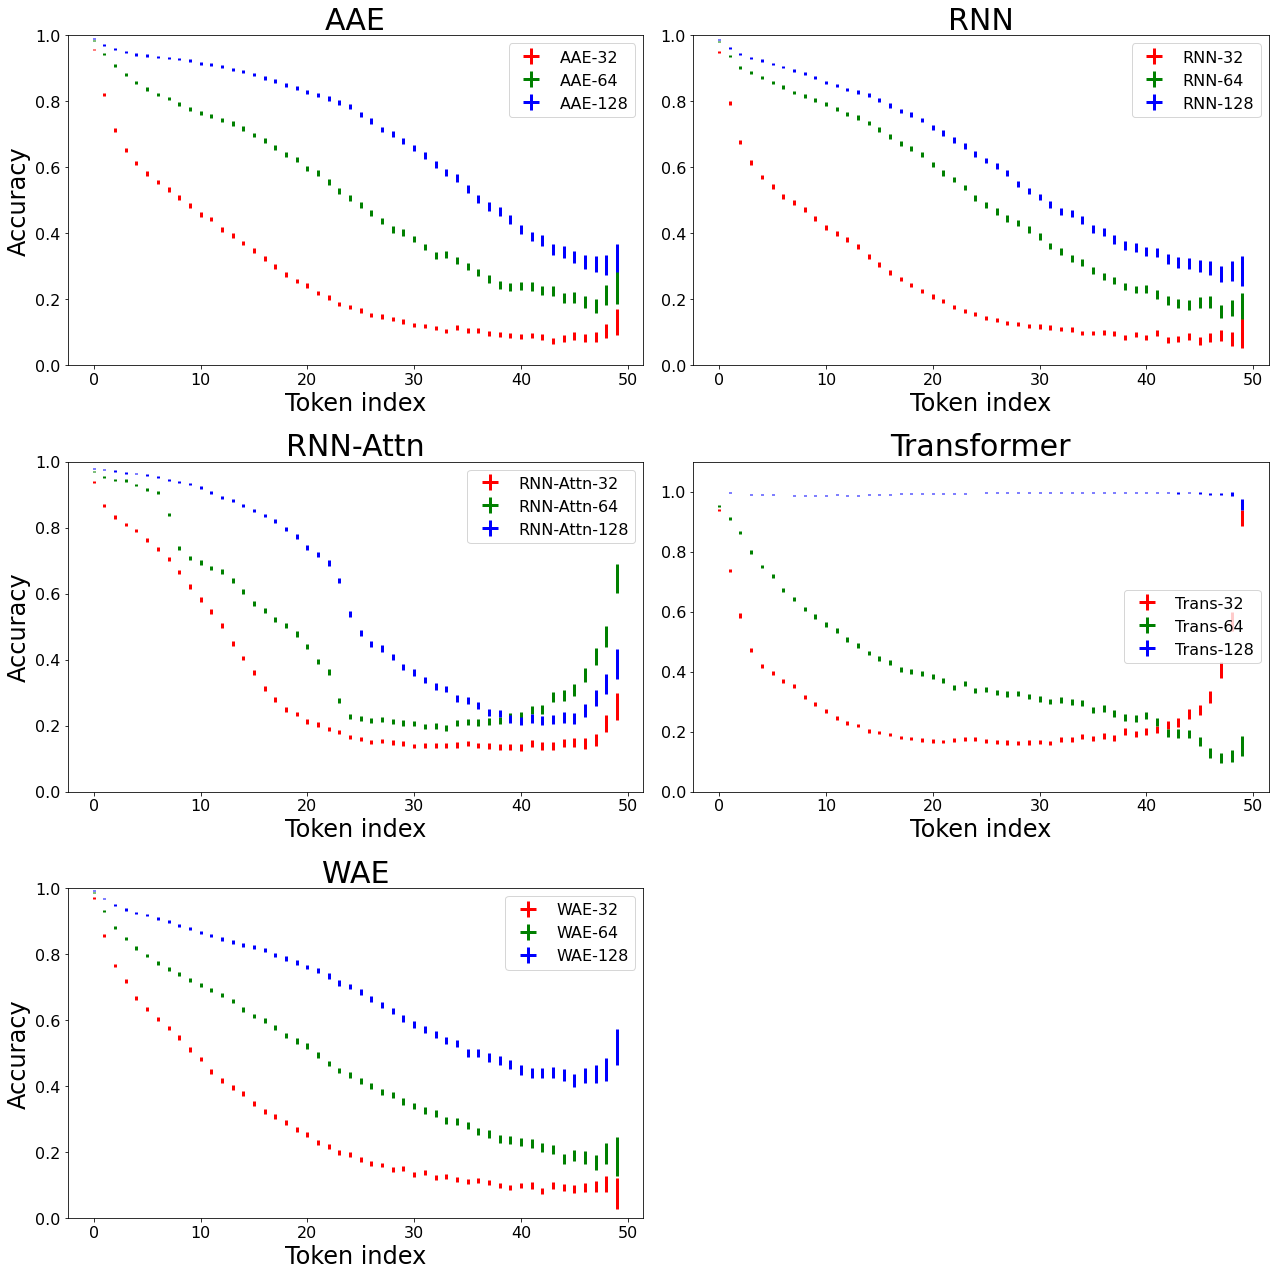

In [12]:
fig = plt.figure(figsize=(18,18))
SMALL_SIZE = 16
MEDIUM_SIZE = 24
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

lw = 3 #linewidth
ax1 = plt.subplot2grid(shape=(3,2), loc=(0,0), colspan=1)

img = ax1.errorbar(x=range(len(pos_acc_list[0].dropna())), y=pos_acc_list[0].dropna(),
                   xerr=0,yerr=pos_err_list[0].dropna(),fmt='none',ecolor='r',elinewidth=lw)
ax1.errorbar(x=range(len(pos_acc_list[1].dropna())), y=pos_acc_list[1].dropna(),
                   xerr=0,yerr=pos_err_list[1].dropna(),fmt='none',ecolor='g',elinewidth=lw)
ax1.errorbar(x=range(len(pos_acc_list[2].dropna())), y=pos_acc_list[2].dropna(),
                   xerr=0,yerr=pos_err_list[2].dropna(),fmt='none',ecolor='b',elinewidth=lw)
ax1.set_title('AAE')
ax1.legend(['AAE-32','AAE-64','AAE-128'])
ax1.set_ylim([0, 1])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Token index')
# plt.show(img)

ax2 = plt.subplot2grid((3,2), (0,1), colspan=1)
ax2.errorbar(x=range(len(pos_acc_list[3].dropna())), y=pos_acc_list[3].dropna(),
                   xerr=0,yerr=pos_err_list[3].dropna(),fmt='none',ecolor='r',elinewidth=lw)
ax2.errorbar(x=range(len(pos_acc_list[4].dropna())), y=pos_acc_list[4].dropna(),
                   xerr=0,yerr=pos_err_list[4].dropna(),fmt='none',ecolor='g',elinewidth=lw)
ax2.errorbar(x=range(len(pos_acc_list[5].dropna())), y=pos_acc_list[5].dropna(),
                   xerr=0,yerr=pos_err_list[5].dropna(),fmt='none',ecolor='b',elinewidth=lw)
ax2.set_title('RNN')
ax2.legend(['RNN-32','RNN-64','RNN-128'])
ax2.set_ylim([0, 1])
ax2.set_ylabel('')
ax2.set_xlabel('Token index')
# plt.show(img)

ax3 = plt.subplot2grid((3,2), (1,0), colspan=1)
ax3.errorbar(x=range(len(pos_acc_list[6].dropna())), y=pos_acc_list[6].dropna(),
                   xerr=0,yerr=pos_err_list[6].dropna(),fmt='none',ecolor='r',elinewidth=lw)
ax3.errorbar(x=range(len(pos_acc_list[7].dropna())), y=pos_acc_list[7].dropna(),
                   xerr=0,yerr=pos_err_list[7].dropna(),fmt='none',ecolor='g',elinewidth=lw)
ax3.errorbar(x=range(len(pos_acc_list[8].dropna())), y=pos_acc_list[8].dropna(),
                   xerr=0,yerr=pos_err_list[8].dropna(),fmt='none',ecolor='b',elinewidth=lw)
ax3.set_title('RNN-Attn')
ax3.legend(['RNN-Attn-32','RNN-Attn-64','RNN-Attn-128'])
ax3.set_ylim([0, 1])
ax3.set_ylabel('Accuracy')
ax3.set_xlabel('Token index')
# plt.show(img)

ax4 = plt.subplot2grid((3,2), (1,1), colspan=1)
ax4.errorbar(x=range(len(pos_acc_list[9].dropna())), y=pos_acc_list[9].dropna(),
                   xerr=0,yerr=pos_err_list[9].dropna(),fmt='none',ecolor='r',elinewidth=lw)
ax4.errorbar(x=range(len(pos_acc_list[10].dropna())), y=pos_acc_list[10].dropna(),
                   xerr=0,yerr=pos_err_list[10].dropna(),fmt='none',ecolor='g',elinewidth=lw)
ax4.errorbar(x=range(len(pos_acc_list[11].dropna())), y=pos_acc_list[11].dropna(),
                   xerr=0,yerr=pos_err_list[11].dropna(),fmt='none',ecolor='b',elinewidth=lw)
ax4.set_title('Transformer')
ax4.legend(['Trans-32','Trans-64','Trans-128'], loc='center right')
ax4.set_ylim([0, 1.1])
ax4.set_ylabel('')
ax4.set_xlabel('Token index')
# plt.show(img)

ax5 = plt.subplot2grid((3,2), (2,0), colspan=1)
ax5.errorbar(x=range(len(pos_acc_list[12].dropna())), y=pos_acc_list[12].dropna(),
                   xerr=0,yerr=pos_err_list[12].dropna(),fmt='none',ecolor='r',elinewidth=lw)
ax5.errorbar(x=range(len(pos_acc_list[13].dropna())), y=pos_acc_list[13].dropna(),
                   xerr=0,yerr=pos_err_list[13].dropna(),fmt='none',ecolor='g',elinewidth=lw)
ax5.errorbar(x=range(len(pos_acc_list[14].dropna())), y=pos_acc_list[14].dropna(),
                   xerr=0,yerr=pos_err_list[14].dropna(),fmt='none',ecolor='b',elinewidth=lw)
ax5.set_title('WAE')
ax5.legend(['WAE-32','WAE-64','WAE-128'])
ax5.set_ylim([0, 1])
ax5.set_ylabel('Accuracy')
ax5.set_xlabel('Token index')
plt.tight_layout()
plt.savefig('position_acc.png',transparent=False, dpi=600)
plt.show(img)



In [13]:
acc_list = []
for df_tuple in df_list:
    acc_list.append([df_tuple[0].loc[0,'property prediction accuracy'],
                      df_tuple[0].loc[0,'property prediction confidence'],
                      df_tuple[0].loc[1,'property prediction confidence'],
                      'Property Prediction Accuracy'])
    acc_list.append([df_tuple[0].loc[0,'sequence accuracy'],
                      df_tuple[0].loc[0,'sequence confidence'],
                      df_tuple[0].loc[1,'sequence confidence'],
                      'Entire Sequence Reconstruction Accuracy'])
    acc_list.append([df_tuple[0].loc[0,'token accuracy'],
                      df_tuple[0].loc[0,'token confidence'],
                      df_tuple[0].loc[1,'token confidence'],
                      'Average per-Token Reconstruction Accuracy'])
    acc_list.append(df_tuple[0]['model'][0])

C:\Users\s_renaud\AppData\Local\Temp/ipykernel_14884/2310085512.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[col].set_xticklabels(['AAE','RNN','RNN-Attention','Transformer','WAE'])
C:\Users\s_renaud\AppData\Local\Temp/ipykernel_14884/2310085512.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[col].set_xticklabels(['AAE','RNN','RNN-Attention','Transformer','WAE'])
C:\Users\s_renaud\AppData\Local\Temp/ipykernel_14884/2310085512.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[col].set_xticklabels(['AAE','RNN','RNN-Attention','Transformer','WAE'])


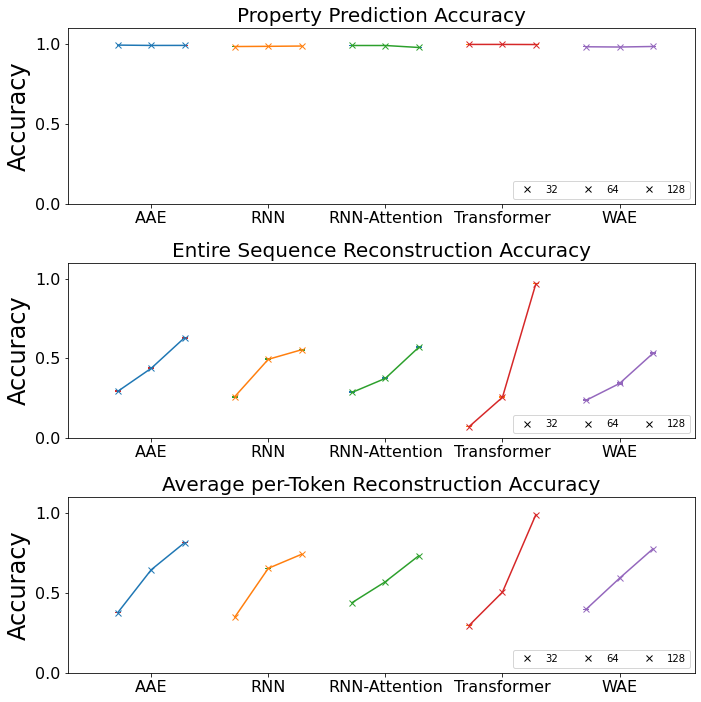

In [14]:
fig, ax = plt.subplots((len(acc_list)//len(namelist)-1),1, figsize=(10,10))

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
x_labels=[0.8,1,1.2]

lw=6

for col in range((len(acc_list)//len(namelist)-1)):
    err_1 = ax[col].errorbar(x=np.array(x_labels),
                     y=[elmt[0] for elmt in acc_list[col:3*len(acc_list)//len(namelist):len(acc_list)//len(namelist)]],
                     yerr=[elmt[1] for elmt in acc_list[col:3*len(acc_list)//len(namelist):len(acc_list)//len(namelist)]],
                     fmt='-x',elinewidth=lw,
                     ecolor=['tab:red'])
    err_2 = ax[col].errorbar(x=np.array(x_labels)+(0.7*1),
                     y=[elmt[0] for elmt in acc_list[col+3*len(acc_list)//len(namelist):6*len(acc_list)//len(namelist):len(acc_list)//len(namelist)]],
                     yerr=[elmt[1] for elmt in acc_list[col+3*len(acc_list)//len(namelist):6*len(acc_list)//len(namelist):len(acc_list)//len(namelist)]],
                     fmt='-x',elinewidth=lw,
                     ecolor=['tab:green'])
    err_3 = ax[col].errorbar(x=np.array(x_labels)+(0.7*2),
                     y=[elmt[0] for elmt in acc_list[col+6*len(acc_list)//len(namelist):9*len(acc_list)//len(namelist):len(acc_list)//len(namelist)]],
                     yerr=[elmt[1] for elmt in acc_list[col+6*len(acc_list)//len(namelist):9*len(acc_list)//len(namelist):len(acc_list)//len(namelist)]],
                     fmt='-x',elinewidth=lw,
                     ecolor=['tab:blue'])
    err_4 = ax[col].errorbar(x=np.array(x_labels)+(0.7*3),
                     y=[elmt[0] for elmt in acc_list[col+9*len(acc_list)//len(namelist):12*len(acc_list)//len(namelist):len(acc_list)//len(namelist)]],
                     yerr=[elmt[1] for elmt in acc_list[col+9*len(acc_list)//len(namelist):12*len(acc_list)//len(namelist):len(acc_list)//len(namelist)]],
                     fmt='-x',elinewidth=lw,
                     ecolor=['tab:orange'])
    err_5 = ax[col].errorbar(x=np.array(x_labels)+(0.7*4),
                     y=[elmt[0] for elmt in acc_list[col+12*len(acc_list)//len(namelist):15*len(acc_list)//len(namelist):len(acc_list)//len(namelist)]],
                     yerr=[elmt[1] for elmt in acc_list[col+12*len(acc_list)//len(namelist):15*len(acc_list)//len(namelist):len(acc_list)//len(namelist)]],
                     fmt='-x',elinewidth=lw,
                     ecolor=['tab:purple'])
                     
    ax[col].set_title(acc_list[col::(len(acc_list)//len(namelist))][0][-1])
    ax[col].set_xticklabels(['AAE','RNN','RNN-Attention','Transformer','WAE'])
    ax[col].set_xticks([1,1+(0.7*1),1+(0.7*2),1+(0.7*3),1+(0.7*4)])
    ax[col].set_ylabel('Accuracy')
    kp, =plt.plot([],'kx')
    ax[col].legend((kp,kp,kp),['32','64','128'],ncol=3,loc='lower right')
    kp.remove()
    ax[col].set_xlim(0.5,4.25)
    ax[col].set_ylim(0,1.1)
plt.tight_layout()
plt.savefig('bar_metrics.jpg', transparent=True, dpi=200)
plt.show()

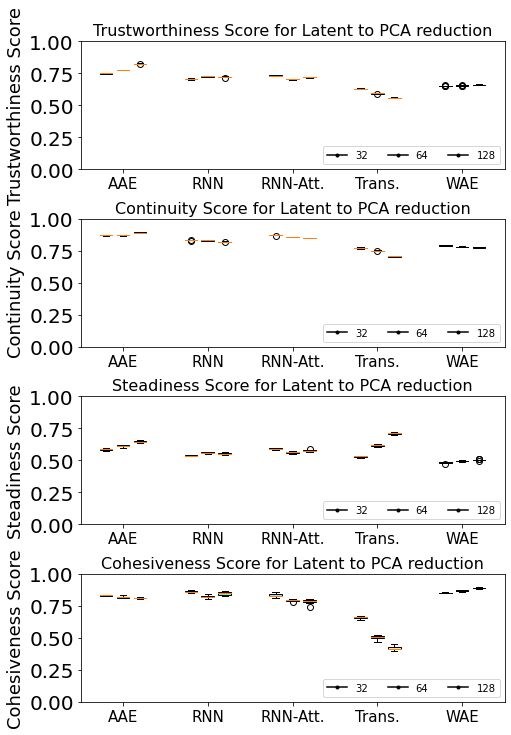

In [15]:
fig, ax = plt.subplots(4,1, figsize=(7,10))

color_list =['lightcoral','lightgreen','lightblue', 'moccasin', 'plum',]
title_list=['Trustworthiness Score for Latent to PCA reduction', 'Continuity Score for Latent to PCA reduction',
            'Steadiness Score for Latent to PCA reduction','Cohesiveness Score for Latent to PCA reduction']
# y_labels=['Average Entropy', 'Silhouette Score','Silhouette Score','Trustworthiness Score','Continuity Score',
#          'LCMC Score','Steadiness Score', 'Cohesiveness Score']
y_labels=['Trustworthiness Score','Continuity Score','Steadiness Score', 'Cohesiveness Score']
x_labels=['aae-32','aae-64','aae-128','rnn-32','rnn-64','rnn-128','rnnattn-32','rnnattn-64','rnnattn-128',
         'trans-32','trans-64','trans-128','wae-32','wae-64','wae-128']

SMALL_SIZE = 9
MEDIUM_SIZE = 15
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=13)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels

positions=[0.8,1,1.2, 1.8,2,2.2, 2.8,3,3.2, 3.8,4,4.2, 4.8,5,5.2]
widths=0.15
skip=0
for col in range(14):
    if col<9:
        continue
    axis_box = col-9
    if col==11:
        skip-=1
        continue
    axis_box = axis_box+skip

    box_1 = ax[axis_box].boxplot(x=[elmt[0] for elmt in metric_list[col+3:3*(len(metric_list)//len(namelist)):(len(metric_list)//len(namelist))]],
                            positions=positions[0:3],widths=widths, patch_artist=True) 
    box_2 = ax[axis_box].boxplot(x=[elmt[0] for elmt in metric_list[col+3+3*(len(metric_list)//len(namelist)):6*(len(metric_list)//len(namelist)):(len(metric_list)//len(namelist))]],
                            positions=positions[3:6],widths=widths, patch_artist=True) 
    box_3 = ax[axis_box].boxplot(x=[elmt[0] for elmt in metric_list[col+3+6*(len(metric_list)//len(namelist)):9*(len(metric_list)//len(namelist)):(len(metric_list)//len(namelist))]],
                            positions=positions[6:9],widths=widths, patch_artist=True) 
    box_4 = ax[axis_box].boxplot(x=[elmt[0] for elmt in metric_list[col+3+9*(len(metric_list)//len(namelist)):12*(len(metric_list)//len(namelist)):(len(metric_list)//len(namelist))]],
                            positions=positions[9:12],widths=widths, patch_artist=True) 
    box_5 = ax[axis_box].boxplot(x=[elmt[0] for elmt in metric_list[col+3+12*(len(metric_list)//len(namelist)):15*(len(metric_list)//len(namelist)):(len(metric_list)//len(namelist))]],
                            positions=positions[12:15],widths=widths, patch_artist=True)
    for box, color in zip([box_1,box_2,box_3,box_4,box_5], color_list):
        for patch in box['boxes']: 
            patch.set_facecolor(color)
        
    plt.setp(box['medians'],color='black')
    ax[axis_box].set_title(title_list[axis_box])
    ax[axis_box].set_ylabel(y_labels[axis_box])
    ax[axis_box].set_xticklabels(['-','AAE','-','-','RNN','-','-','RNN-Att.','-','-','Trans.','-','-','WAE','-'])
    ax[axis_box].set_xticks([1, 2, 3, 4, 5])
    ax[axis_box].set_xlim(0.5,5.5)
    kp, = plt.plot([],'k.-')
    ax[axis_box].legend((kp,kp,kp),['32','64','128'],ncol=3, loc='lower right')
    ax[axis_box].set_ylim(0,1)
    kp.remove()
plt.tight_layout()
plt.savefig('pca_metrics.jpg', transparent=True,dpi=200)
plt.show()

<H3>NEW section for generation metrics 

In [32]:
df_list = []
glob_list = glob.glob("model_analyses\\train//"+"//**//*cs.csv", recursive = True) #searcg all the analyses to find the CSV's

ordered_glob_list = sorted_alphanumeric(glob_list) #problems with default ordering

for csv in ordered_glob_list:
    df_list.append([pd.read_csv(csv),csv]) #create and store a tuple which contains the dataframe and the directory
    print(csv)

model_analyses\train\aae-128_peptide_latent32_train\generation_metrics.csv
model_analyses\train\aae-128_peptide_latent64_train\generation_metrics.csv
model_analyses\train\aae-128_peptide_latent128_train\generation_metrics.csv
model_analyses\train\rnn-128_peptide_latent32_train\generation_metrics.csv
model_analyses\train\rnn-128_peptide_latent64_train\generation_metrics.csv
model_analyses\train\rnn-128_peptide_latent128_train\generation_metrics.csv
model_analyses\train\rnnattn-128_peptide_latent32_train\generation_metrics.csv
model_analyses\train\rnnattn-128_peptide_latent64_train\generation_metrics.csv
model_analyses\train\rnnattn-128_peptide_latent128_train\generation_metrics.csv
model_analyses\train\trans1x-128_peptide_latent32_train\generation_metrics.csv
model_analyses\train\trans1x-128_peptide_latent64_train\generation_metrics.csv
model_analyses\train\trans1x-128_peptide_latent128_train\generation_metrics.csv
model_analyses\train\wae-128_peptide_latent32_train\generation_metrics.c

In [33]:
#some scores need confidence intervals calculated which is done below. Also the model name is appended at the end of the df
#also store the results to be printed in a "metric_list"
sampling_metrics=[]

for df_tuple in df_list:
    sampling_metrics.append([df_tuple[0].loc[0,'percent_unique'],
                      df_tuple[0].loc[0,'unique_confidence'],
                      'Uniqueness Score'])
    sampling_metrics.append([df_tuple[0].loc[0,'percent_novel'],
                      df_tuple[0].loc[0,'novel_confidence'],
                      'Novelty'])
        
    model_name = df_tuple[1].split('\\')[-2]
    model_name = model_name.split('_')[0][:-4]+'-'+model_name.split('_')[2][6:]
    
    sampling_metrics.append(model_name)

C:\Users\s_renaud\AppData\Local\Temp/ipykernel_14884/2076041558.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[col].set_xticklabels(['','AAE','RNN','RNN-Attention','Transformer','WAE'])
C:\Users\s_renaud\AppData\Local\Temp/ipykernel_14884/2076041558.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[col].set_xticklabels(['','AAE','RNN','RNN-Attention','Transformer','WAE'])


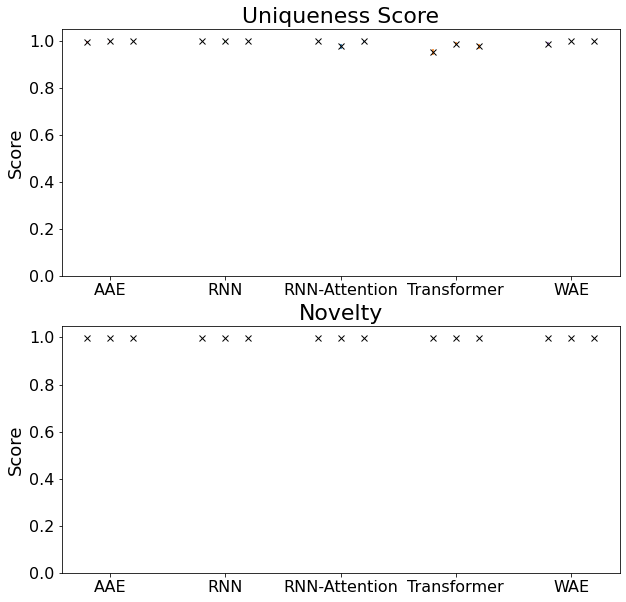

In [34]:
fig, ax = plt.subplots((len(sampling_metrics)//len(namelist)-1),1, figsize=(10,10))

plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels

x_labels=[0.8,1,1.2, 1.8,2,2.2, 2.8,3,3.2, 3.8,4,4.2, 4.8,5,5.2]

for col in range((len(sampling_metrics)//len(namelist)-1)):
    err_1 = ax[col].errorbar(x=x_labels[0:3],
                     y=[elmt[0] for elmt in sampling_metrics[col:3*len(sampling_metrics)//len(namelist):len(sampling_metrics)//len(namelist)]],
                     yerr=[elmt[1] for elmt in sampling_metrics[col:3*len(sampling_metrics)//len(namelist):len(sampling_metrics)//len(namelist)]],
                     fmt='kx',
                     ecolor=['tab:red'])
    err_2 = ax[col].errorbar(x=x_labels[3:6],
                     y=[elmt[0] for elmt in sampling_metrics[col+3*len(sampling_metrics)//len(namelist):6*len(sampling_metrics)//len(namelist):len(sampling_metrics)//len(namelist)]],
                     yerr=[elmt[1] for elmt in sampling_metrics[col+3*len(sampling_metrics)//len(namelist):6*len(sampling_metrics)//len(namelist):len(sampling_metrics)//len(namelist)]],
                     fmt='kx',
                     ecolor=['tab:green'])
    err_3 = ax[col].errorbar(x=x_labels[6:9],
                     y=[elmt[0] for elmt in sampling_metrics[col+6*len(sampling_metrics)//len(namelist):9*len(sampling_metrics)//len(namelist):len(sampling_metrics)//len(namelist)]],
                     yerr=[elmt[1] for elmt in sampling_metrics[col+6*len(sampling_metrics)//len(namelist):9*len(sampling_metrics)//len(namelist):len(sampling_metrics)//len(namelist)]],
                     fmt='kx',
                     ecolor=['tab:blue'])
    err_4 = ax[col].errorbar(x=x_labels[9:12],
                     y=[elmt[0] for elmt in sampling_metrics[col+9*len(sampling_metrics)//len(namelist):12*len(sampling_metrics)//len(namelist):len(sampling_metrics)//len(namelist)]],
                     yerr=[elmt[1] for elmt in sampling_metrics[col+9*len(sampling_metrics)//len(namelist):12*len(sampling_metrics)//len(namelist):len(sampling_metrics)//len(namelist)]],
                     fmt='kx',
                     ecolor=['tab:orange'])
    err_5 = ax[col].errorbar(x=x_labels[12:15],
                     y=[elmt[0] for elmt in sampling_metrics[col+12*len(sampling_metrics)//len(namelist):15*len(sampling_metrics)//len(namelist):len(sampling_metrics)//len(namelist)]],
                     yerr=[elmt[1] for elmt in sampling_metrics[col+12*len(sampling_metrics)//len(namelist):15*len(sampling_metrics)//len(namelist):len(sampling_metrics)//len(namelist)]],
                     fmt='kx',
                     ecolor=['tab:purple'])
    ax[col].set_title(sampling_metrics[col::(len(sampling_metrics)//len(namelist))][0][-1])
    ax[col].set_xticklabels(['','AAE','RNN','RNN-Attention','Transformer','WAE'])
    ax[col].set_ylabel('Score')
    ax[col].set_ylim(0,1.05)
plt.savefig('extra_metrics.jpg', transparent=True, dpi=200)
plt.show()

In [44]:
sampling_metrics=[]
for df_tuple in df_list:
    for idx in range(10):
        sampling_metrics.append([df_tuple[0].loc[0,'average_sequence_similarity_'+str(idx)],
                                 df_tuple[0].loc[0,'std_on_similarity_score_'+str(idx)],
                                 'Average Sequence Similarity Score '+str(idx)])
        sampling_metrics.append([df_tuple[0].loc[0,'amp_uniqueness_'+str(idx)],
                                 df_tuple[0].loc[0,'amp_uniqueness_std_'+str(idx)],
                                 'Amp Uniqueness Score '+str(idx)])
        sampling_metrics.append([df_tuple[0].loc[0,'amp_jac_score_2_'+str(idx)],
                                 df_tuple[0].loc[0,'amp_jac_score_std_2_'+str(idx)],
                                 'Amp Jaccard 2mer Similarity Score '+str(idx)])
        sampling_metrics.append([df_tuple[0].loc[0,'amp_jac_score_3_'+str(idx)],
                                 df_tuple[0].loc[0,'amp_jac_score_std_3_'+str(idx)],
                                 'Amp Jaccard 3mer Similarity Score '+str(idx)])

In [45]:
sampling_metrics

[[0.8098012569647568,
  0.1311440211772398,
  'Average Sequence Similarity Score 0'],
 [1.0, 0.0, 'Amp Uniqueness Score 0'],
 [0.085933786383761,
  0.0399040010164692,
  'Amp Jaccard 2mer Similarity Score 0'],
 [0.009884673191617,
  0.0126493412519072,
  'Amp Jaccard 3mer Similarity Score 0'],
 [0.7058654671263859,
  0.1401005300280828,
  'Average Sequence Similarity Score 1'],
 [1.0, 0.0, 'Amp Uniqueness Score 1'],
 [0.0703831685957554,
  0.0377732540842827,
  'Amp Jaccard 2mer Similarity Score 1'],
 [0.008080364497929,
  0.0113016360807879,
  'Amp Jaccard 3mer Similarity Score 1'],
 [0.7169346127035247,
  0.1512199964080329,
  'Average Sequence Similarity Score 2'],
 [1.0, 0.0, 'Amp Uniqueness Score 2'],
 [0.0625180189443377,
  0.038258657959893,
  'Amp Jaccard 2mer Similarity Score 2'],
 [0.0082944706302294,
  0.0126981787323953,
  'Amp Jaccard 3mer Similarity Score 2'],
 [0.7187195681099191,
  0.175264031972434,
  'Average Sequence Similarity Score 3'],
 [1.0, 0.0, 'Amp Uniqueness 

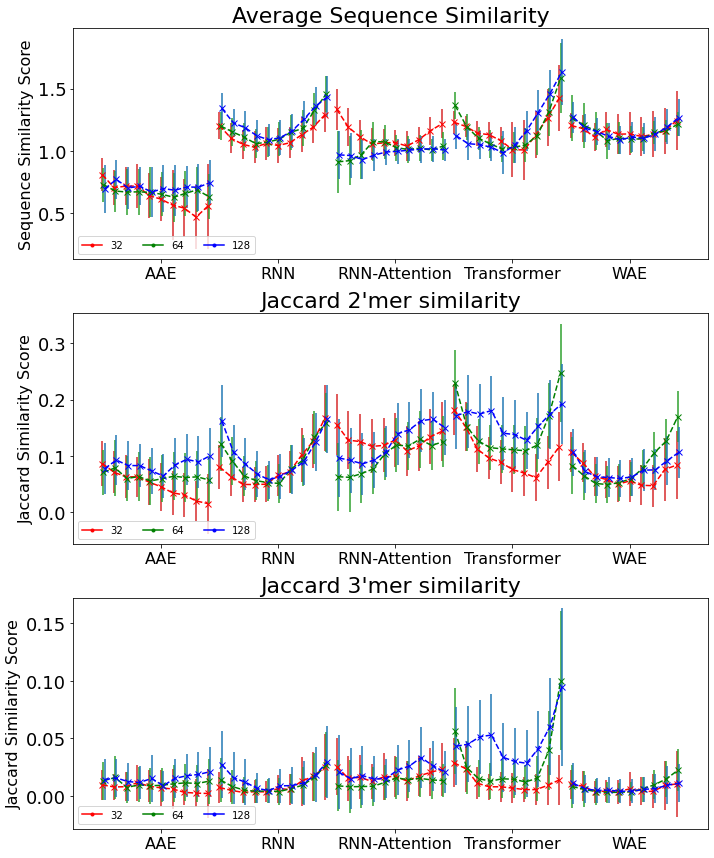

In [52]:
fig, ax = plt.subplots(3,1, figsize=(10,12)) 

titles=['Average Sequence Similarity','Uniqueness','Jaccard 2\'mer similarity', 'Jaccard 3\'mer similarity']
y_labels = ['Sequence Similarity Score', 'Fraction Unique', 'Jaccard Similarity Score','Jaccard Similarity Score']


plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels

x_labels=[0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]
skip=0
for col in range(5):
    for axis in range(4):
        if axis==0:
            skip= 0
        if axis==1:
            skip= -1
            continue
        ax_box = axis+skip
        err_1 = ax[ax_box].errorbar(x=np.array(x_labels)+col,
                             y=[elmt[0] for elmt in sampling_metrics[axis+col*120:col*120+40:4]],
                             yerr=[elmt[1] for elmt in sampling_metrics[axis+col*120:col*120+40:4]],
                             fmt='rx--',
                             ecolor=['tab:red'])

        err_1 = ax[ax_box].errorbar(x=np.array(x_labels)+0.01+col,
                             y=[elmt[0] for elmt in sampling_metrics[axis+col*120+40:col*120+80:4]],
                             yerr=[elmt[1] for elmt in sampling_metrics[axis+col*120+40:col*120+80:4]],
                             fmt='gx--',
                             ecolor=['tab:green'])

        err_1 = ax[ax_box].errorbar(x=np.array(x_labels)+0.02+col,
                             y=[elmt[0] for elmt in sampling_metrics[axis+col*120+80:col*120+120:4]],
                             yerr=[elmt[1] for elmt in sampling_metrics[axis+col*120+80:col*120+120:4]],
                             fmt='bx--',
                             ecolor=['tab:blue'])
        
        ax[ax_box].set_title(titles[axis])
        ax[ax_box].set_xticks([1, 2, 3, 4, 5])
        ax[ax_box].set_xticklabels(['AAE','RNN','RNN-Attention','Transformer','WAE'])
        ax[ax_box].set_ylabel(y_labels[axis])
        kp, = plt.plot([],'r.-')
        gp, = plt.plot([],'g.-')
        bp, = plt.plot([],'b.-')
        ax[ax_box].legend((kp,gp,bp),['32','64','128'],ncol=3, loc='lower left')
plt.tight_layout()    
plt.savefig('sequence_sampling_metrics.jpg', transparent=True, dpi=200 )


<H3> This new section reads the output from AMPlify and turns it into graphs

In [21]:
import glob
import re
import pandas as pd
import numpy as np
df_list = []
glob_list = glob.glob("..\..\..\\amplify\\data\\model_analyses\\train//"+"//**//*.tsv", recursive = True) #searcg all the analyses to find the CSV's

ordered_glob_list = sorted_alphanumeric(glob_list) #problems with default ordering

for tsv in ordered_glob_list:
    df_list.append((pd.read_csv(tsv, sep='\t'), tsv.split('\\')[-2].split('_')[0]))

In [22]:
model_result_list=[]
for model in df_list:
    prediction_list = [model[0]['Prediction'][i*30:(i+1)*30] for i in range(10)]

    amp_fraction_list=[]
    for location in prediction_list:
        value_counts = location.value_counts()
        if 'AMP' not in value_counts:
            amp_fraction_list.append(0)
        elif 'non-AMP' not in value_counts:
            amp_fraction_list.append(1)
        else: amp_fraction_list.append(int(value_counts['AMP'])/int(value_counts['non-AMP']+value_counts['AMP']))
        
    model_result_list.append(amp_fraction_list)

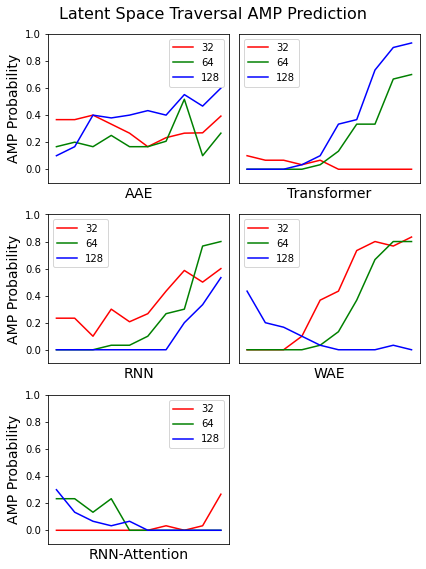

In [23]:
x_labels=['AAE','RNN','RNN-Attention','Transformer','WAE']
titles = ['Latent Space Traversal AMP Prediction','Latent Space Traversal AMP Prediction',
          'Latent Space Traversal AMP Prediction','Latent Space Traversal AMP Prediction',
          'Latent Space Traversal AMP Prediction']
y_labels= ['AMP Probability','AMP Probability','AMP Probability',
          'AMP Probability','AMP Probability',]

plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels

fig, ax = plt.subplots(3,2, figsize=(6,8))
for i in range(5):
    if i >=3:
        a=i%3
        b=1
    else: 
        a=i
        b=0
    ax[a,b].plot(model_result_list[i*3],'r',label='32')
    ax[a,b].plot(model_result_list[(i*3)+1],'g', label='64')
    ax[a,b].plot(model_result_list[(i*3)+2],'b', label='128')
    ax[a,b].set_xlabel(x_labels[i])
    ax[a,b].set_ylabel(y_labels[i])
    ax[a,b].legend()
    ax[a,b].tick_params(bottom=False, labelbottom=False)
    ax[a,b].set_ylim(-0.1,1)
   # ax[a,b].set_title(titles[i])
    
fig.suptitle('Latent Space Traversal AMP Prediction', fontsize=16)
ax[1,1].set_ylabel('')
ax[0,1].set_ylabel('')
ax[1,1].tick_params(left=False, labelleft=False)
ax[0,1].tick_params(left=False, labelleft=False)
fig.delaxes(ax[2][1])
plt.tight_layout()
plt.savefig('amplify_scores.jpg', transparent=True, dpi=200)
plt.show()



<H3> Plotting the Pearson and Spearman correlations

In [24]:
df_list = []
glob_list = glob.glob("model_analyses\\train//"+"//**//*r.csv", recursive = True) #searcg all the analyses to find the CSV's

ordered_glob_list = sorted_alphanumeric(glob_list) #problems with default ordering

for csv in ordered_glob_list:
    df_list.append((pd.read_csv(csv),csv.split('\\')[-2].split('_')[0]+'_'+csv.split('\\')[-2].split('_')[2].replace('latent','')))

In [25]:
amp_spearmanr = [(df[0]['amp_spearmanr'].values,df[1]) for df in df_list]
aliphatic_index =  [(df[0]['aliphatic_index_pearsonr'].values,df[1]) for df in df_list]
boman = [(df[0]['boman_pearsonr'].values,df[1]) for df in df_list]
charge_ph3 = [(df[0]['charge_ph3_pearsonr'].values,df[1]) for df in df_list]
charge_ph7 = [(df[0]['charge_ph7_pearsonr'].values,df[1]) for df in df_list]
charge_ph9 = [(df[0]['charge_ph9_pearsonr'].values,df[1]) for df in df_list]
hydrophobic_moment = [(df[0]['hydrophobic_moment_pearsonr'].values,df[1]) for df in df_list]
hydrophobicity = [(df[0]['hydrophobicity_pearsonr'].values,df[1]) for df in df_list]
instability_index = [(df[0]['instability_index_pearsonr'].values,df[1]) for df in df_list]
isoelectric_point = [(df[0]['isoelectric_point_pearsonr'].values,df[1]) for df in df_list]
molecular_weight = [(df[0]['molecular_weight_pearsonr'].values,df[1]) for df in df_list]
correlation_list = [amp_spearmanr,aliphatic_index,boman,charge_ph3,charge_ph7,charge_ph9,hydrophobic_moment,
                    hydrophobicity,instability_index,isoelectric_point,molecular_weight]

In [26]:
correlation_data = []
for correlation in correlation_list:
    best_pc_list=[]
    for item in correlation:
        cor_list = [np.abs(np.array(eval(cor)[0])) for cor in item[0]]
        print(np.argmax(cor_list))
        best_pc_list.append((np.argmax(cor_list), np.max(cor_list), item[1]))
    correlation_data.append(best_pc_list)

0
4
1
2
2
3
4
0
0
2
1
3
2
3
2
3
2
3
1
2
1
3
4
4
1
0
1
2
2
4
3
1
4
1
1
1
3
4
2
0
0
2
2
4
4
3
2
4
2
1
1
4
3
4
0
0
2
1
1
4
3
2
4
2
1
2
4
3
4
2
1
2
1
1
2
4
2
4
2
3
2
4
3
1
3
1
2
3
4
3
0
0
0
0
0
0
0
0
0
2
1
3
2
0
0
4
4
4
1
3
1
3
1
1
0
0
1
2
2
4
2
4
4
1
2
3
1
0
4
0
0
2
0
1
2
3
2
4
2
1
2
4
3
4
3
1
2
3
4
4
0
0
0
0
0
0
0
0
0
2
4
3
3
0
0


In [27]:
correlation_data[0]

[(0, 0.13590680193503685, 'aae-128_32'),
 (4, 0.24223729310211367, 'aae-128_64'),
 (1, 0.2691778636083085, 'aae-128_128'),
 (2, 0.14013328830390756, 'rnn-128_32'),
 (2, 0.1016481876111332, 'rnn-128_64'),
 (3, 0.14445155953329883, 'rnn-128_128'),
 (4, 0.11063783713717877, 'rnnattn-128_32'),
 (0, 0.0635428562436476, 'rnnattn-128_64'),
 (0, 0.09218861765270253, 'rnnattn-128_128'),
 (2, 0.16957094637805262, 'trans1x-128_32'),
 (1, 0.1111733725361142, 'trans1x-128_64'),
 (3, 0.22369076831197732, 'trans1x-128_128'),
 (2, 0.2149608855699522, 'wae-128_32'),
 (3, 0.08149171078679321, 'wae-128_64'),
 (2, 0.20008814614942014, 'wae-128_128')]

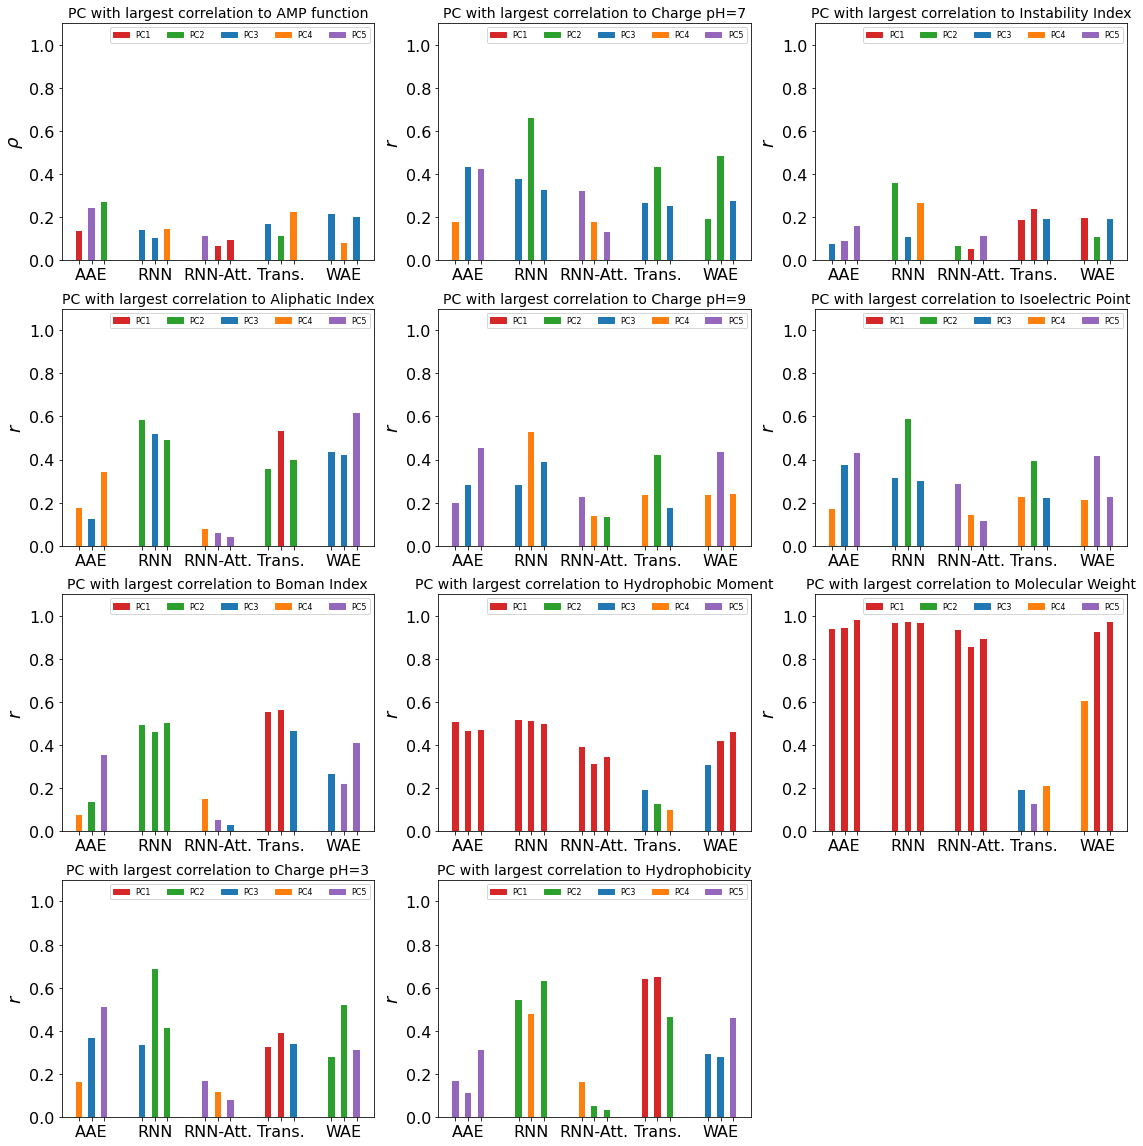

In [28]:
titles= ['PC with largest correlation to AMP function',
         'PC with largest correlation to Aliphatic Index',
         'PC with largest correlation to Boman Index',
         'PC with largest correlation to Charge pH=3',
         'PC with largest correlation to Charge pH=7',
         'PC with largest correlation to Charge pH=9',
         'PC with largest correlation to Hydrophobic Moment',
         'PC with largest correlation to Hydrophobicity',
         'PC with largest correlation to Instability Index',
         'PC with largest correlation to Isoelectric Point',
         'PC with largest correlation to Molecular Weight']
y_axis = [r'$\rho$',r'$r$',r'$r$',r'$r$',r'$r$',
          r'$r$',r'$r$',r'$r$',r'$r$',r'$r$',
          r'$r$',r'$r$',r'$r$',r'$r$',r'$r$']

plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels


positions=[0.8,1,1.2, 1.8,2,2.2, 2.8,3,3.2, 3.8,4,4.2, 4.8,5,5.2]
x_labels = ['','AAE','',
           '','RNN','',
           '','RNN-Att.','',
           '','Trans.','',
           '','WAE','']

fig, ax = plt.subplots(4,3, figsize=(16,16))

for idx,correlation in enumerate(correlation_data):
    if idx>=4:
        a=idx%4
        b=idx//4
    else:
        a=idx
        b=0
    
    num_col_dict = {0:'tab:red',1:'tab:green',2:'tab:blue',3:'tab:orange',4:'tab:purple'}
    np.array([num_col_dict[item[0]] for item in correlation])
    ax[a,b].bar(positions,np.array([item[1] for item in correlation]),
            color=[num_col_dict[item[0]] for item in correlation],
            width=0.1,tick_label=x_labels )

    labels= {'PC1':'tab:red','PC2':'tab:green','PC3':'tab:blue','PC4':'tab:orange','PC5':'tab:purple'}
    handles = [plt.Rectangle((0,0),1,1, color=labels[label]) for label in labels]
    ax[a,b].legend(handles, labels, ncol=5, prop={'size': 8})
    ax[a,b].set_ylabel(y_axis[idx])
    ax[a,b].set_title(titles[idx])
    ax[a,b].set_ylim(0,1.1)
    plt.tight_layout()
plt.delaxes(ax[3,2])
plt.savefig('PC_correlations', transparent=True, dpi=200)


In [29]:
correlation_data[4]

[(3, 0.17878411145648643, 'aae-128_32'),
 (2, 0.4323413008212234, 'aae-128_64'),
 (4, 0.4234295727908296, 'aae-128_128'),
 (2, 0.37647039769949964, 'rnn-128_32'),
 (1, 0.6621793954260669, 'rnn-128_64'),
 (2, 0.32712216454979104, 'rnn-128_128'),
 (4, 0.32233531230281676, 'rnnattn-128_32'),
 (3, 0.17602217290090696, 'rnnattn-128_64'),
 (4, 0.13241693602441132, 'rnnattn-128_128'),
 (2, 0.26450014790426596, 'trans1x-128_32'),
 (1, 0.4307154245757275, 'trans1x-128_64'),
 (2, 0.25039497690202633, 'trans1x-128_128'),
 (1, 0.19298110969163257, 'wae-128_32'),
 (1, 0.48279187421026315, 'wae-128_64'),
 (2, 0.2762287136662661, 'wae-128_128')]